# Explanation

> **Note:** On this page, I'll mainly focus on the original thermodynamic diffusion and denoising diffusion papers that got diffusion started. I've also included the improved denoising diffusion and diffusion beats GANs papers in this repository which add more improvements that I won't be covering here.

Diffusion models have emerged recently (the idea was introduced in 2015, but not really proven until the denoising diffusion paper in 2020), but have quickly matched and surpassed GANs (the previous state-of-the-art models) in image generation quality.

Intuitively, they operate on ideas similar to the VAE - they model complex distributions by learning to deal with the high-level features and noise in the data (like features and noise in images).

Specifically, they work by slowly adding noise to input images ("destroying the structure" of the iamges) in a repetitive process (Markov chain), eventually converting them into complete noise. Then, the diffusion model learns to reverse the process and slowly add structure back into the image, step-by-step.

Conceptually, you can think of a VAE as learning to encode high-level information in the representations produced by the encoder, and then allowing the decoder to add complex details (noise) via random sampling or learning to model complexity. In comparison, diffusion models instead start with noise, and learn to add back the information into images.

### Resources

Diffusion models, especially the denoising diffusion paper, have very challenging math that's difficult to understand. It took me a while to wrap my head around everything.

To help understand what's going on, I'd highly recommend these resources that explain the intuitions and math very well:
- [Why does diffusion work better than auto-regression?](https://www.youtube.com/watch?v=zc5NTeJbk-k)
- [A complete math explanation of the diffusion papers](https://www.youtube.com/watch?v=HoKDTa5jHvg)
- [What are diffusion models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) (blog post with complete math explanation)
- [Generative modeling by estimating gradients of the data-distribution](https://yang-song.net/blog/2021/score/) (intuitive explanation from the perspective of score-based generative models)

### Intuition

Diffusion models work by predictably adding noise to sample images over $T$ timesteps, yielding images $x_0, ..., x_T$ with increasing levels of noise. With these images, we then want to train our model to be able to take in each image $x_t$ and predict the image at the prior time-step $x_{t-1}$ by removing some noise.

We call the original process of adding noise the image the _forward process_, and the process of trying to remove the noise from the image the _reversal process_.

The forward process $q(x_t|x_{t-1})$ follows a predictable schedule to add Gaussian noise to the image over time. This process doesn't involve any trainable parameters - we carry it out deterministically.

Then, we want to train our model $p_\theta(x_{t-1}|x_t)$ to learn to reverse the forward process by adding information and structure back into the image.

Generally, we could think of optimizing our model in terms of maximizing the likelihood $\log p_\theta(x_0|x_T)$ of predicting the original image state from a starting noisy $x_T$ image state - in other words, we want our model to be able to recover the original image through recursive denoising steps.

In practice, calculating this quantity is intractable as it would require us to go back through all possible previous time-steps. So instead, diffusion attempts to accomplish something much simpler.

At each time-step $x_t$, the diffusion model tries to predict the noise added to $x_0$ to create $x_t$. Then, it removes a bit of this noise from the image, and repeats the process.

By using this objective, the model doesn't need to waste parameters learning the specifics of predicting the differences in noise between different time-steps - instead, the model is _always_ predicting the difference in noise between the current time-step and the original image.

So at each time-step, the diffusion model predicts the noise that was added to the image $x_t$ to go from $x_0$ to $x_t$, and then subtracts a bit of this noise and repeats. This can be optimized by calculating the loss as the mean-squared error between the actual noise $\epsilon$ and the predicted noise $\epsilon_\theta$:

$$L_{\textrm{simple}}(\theta) := \mathbb{E}_{t, x_0, \epsilon}[||\epsilon - \epsilon_\theta(\sqrt{\overline{\alpha}_t}x_0 + \sqrt{1 - \overline{\alpha_t}}\epsilon, t)||^2]$$

This apparently intuitive objective function is actually the result of a long derivation with lots of interesting intuitions introduced in the denoising diffusion paper.

For people curious, I'd highly recommend watching [this video](https://www.youtube.com/watch?v=HoKDTa5jHvg) (also linked above) which explains the derivation very well.

In practice, diffusion appears to have a highly effective inductive bias (explored in the papers) that makes it excellent for generating images, conditioning generation on text, image interpolation, and more.

# My Notes

## 📜 [Deep Unsupervised Learning Using Non-equilibrium Thermodynamics](https://arxiv.org/pdf/1503.03585)

> A central problem in machine learning involves modeling complex data-sets using highly flexible families of probability distributions in which learning, sampling, inference, and evaluation are still analytically or computationally tractable.
>

This captures the challenge that all the different probabilistic/generative models have to solve.

> The essential idea, inspired by non-equilibrium statistical physics, is to systematically and slowly destroy structure in a data distribution through an iterative forward diffusion process. We then learn a reverse diffusion process that restores structure in data, yielding a highly flexible and tractable generative model of the data.
>

> Historically, probabilistic models suffer from a tradeoff between two conflicting objectives: tractability and flexibility.
>

**1. Diffusion Probabilistic Models**

> We present a novel way to define probabilistic models that allows:
1. extreme flexibility in model structure
2. exact sampling
3. easy multiplication with other distributions, e.g. in order to compute a posterior, and
4. the model log likelihood, and the probability of individual states, to be cheaply evaluated
>

> Our method uses a Markov chain to gradually convert one distribution into another, an idea used in non-equilibrium statistical physics.
>

The diffusion process slowly converts distributions from more noisy to more structured forms.

> Learning in this framework involves estimating small perturbations to a diffusion process. Estimating small perturbations is more tractable than explicitly describing the full distribution with a single, non-analytically-normalizable, potential function.
>

This is the reason the model does diffusion step-by-step rather than trying to learn the entire original image from noise all at once - the complexity of going from noise straight to the image is so large that it’s intractable, whereas splitting it into many smaller steps actually becomes feasible.

> Since a diffusion process exists for any smooth target distribution, this method can capture data distributions of arbitrary form.
>

### Algorithm

> Our goal is to define a forward (or inference) diffusion process which converts any complex data distribution into a simple, tractable, distribution, and then learn a finite-time reversal of this diffusion process which defines our generative model distribution.
>

**1. Forward Trajectory**

> The data distribution is gradually converted into a well behaved distribution $\pi (y)$ by repeated application of a Markov diffusion kernel $T_\pi(y|y’; \beta)$ for $\pi(y)$ where $\beta$ is the diffusion rate.
>

$$
\pi(y) = \int dy' T_\pi(y|y';\beta)\pi(y') \\
q(x^{(t)}|x^{(t-1)}) = T_\pi(x^{(t)}|x^{(t-1)}; \beta_t)
$$

> The forward trajectory corresponding to starting at the data distribution and performing $T$ steps of diffusion is thus
>

$$
q(x^{(0...T)}) = q(x^{(0)}) \prod_{t=1}^T q(x^{(t)}|x^{(t-1)})
$$

So the forward trajectory is a deterministic noise schedule which is completely predictable - although the mean and variance of the noise are non-consistent, but increase slowly over time via a linear schedule (changed in later papers) so that information isn’t lost from the image too quickly at earlier time-steps.

**2. Reverse Trajectory**

> The generative distribution will be trained to describe the same trajectory, but in reverse.
>

$$
p(x^{(T)}) = \pi(x^{(T)}) \\
p(x^{(0...T)} = p(x^{(T)}) \prod_{t=1}^T p(x^{(t-1)}|x^{(t)})
$$

> During learning only the mean and covariance for a Gaussian diffusion kernel, or the bit flip probability for a binomial kernel, need be estimated
>

In the reverse process, the model learns to predict the noise that was added in the forward process at each step.

**3. Model Probability**

> The probability the generative model assigns to the data is
>

$$
p(x^{(0)}) = \int dx^{(1...T)} p(x^{(0...T)})
$$

In order to actually be able to calculate this integral

> We can instead evaluate the relative probability of the forward and reverse trajectories, averaged over forward trajectories.
>

$$
p(x^{(0)}) = \int dx^{(1...T)}q(x^{(1...T)}|x^{(0)}) \cdot p(x^{(T)}) \prod_{t=1}^T \frac{p(x^{(t-1)}|x^{(t)})}{q(x^{(t)}|x^{(t-1)})}
$$

**4. Training**

Training amounts to maximizing the model log likelihood

$$
L = \int dx^{(0)} q(x^{(0)}) \log p(x^{(0)})
$$

Here, we maximize the likelihood that the model $p$ generates the state $x^{(0)}$ from some noisy state, conditioned by the weight of the actual sample in the dataset $q(x^{(0)})$.

> The derivation of this bound parallels the derivation of the log likelihood bound in variational Bayesian methods.
>

> Training consists of finding the reverse Markov transitions which maximize this lower bound on the log likelihood:
>

$$
\hat{p}(x^{(t-1)}|x^{(t)} = \textrm{argmax}_{p(x^{(t-1)}|x^{(t)})} K
$$

> Thus, the task of estimating a probability distribution has been reduced to the task of performing regression on the functions which set the mean and covariance of a sequence of Gaussians.
>

This whole section shows the reduction of the likelihood function to formally show why we that we can reduce the reversal process to building a network that learns to predict the noise added at each step.

**4.1. Setting the diffusion rate** $\beta_t$

> The choice of $\beta_t$ in the forward trajectory is important for the performance of the trained model.
>

In this paper, the trajectory is set to a linear schedule.

**5 Multiplying Distributions, and Computing Posteriors**

> Tasks such as computing a posterior in order to do signal denoising or inference of missing values requires multiplication of the model distribution $p(x^{(0)})$ with a second distribution or bounded positive function, $r(x^{(0)})$.
>

In order to control the diffusion process to accomplish something we want (like removing noise from an image, or adding missing values), we want to condition the denoising process with another distribution to make the model not just predict the diffusion toward the original image, but pull it slightly toward some other distribution as well.

> Multiplying distributions is costly and difficult for many techniques, including variational autoencoders. However, under a diffusion model it is straightforward, since the second distribution can be treated either as a small perturbation to each step in the diffusion.
>

In the diffusion process, it’s possible to slowly move the diffusion toward some other distribution by introducing the small effects of that distribution into each step of the process.

### Experiments

> We train diffusion probabilistic models on a variety of continuous datasets, and a binary dataset. We then demonstrate sampling from the trained model and in-painting of missing data, and compare model performance against.
>

![Screenshot 2024-05-18 at 3.10.57 PM.png](../../images/Screenshot_2024-05-18_at_3.10.57_PM.png)

### Conclusion

> We have introduced a novel algorithm for modeling probability distributions that enables exact sampling and evaluation of probabilities and demonstrated its effectiveness on a variety of toy and real datasets, including challenging natural image datasets.
>

> The result is an algorithm that can learn a fit to any data distribution, but which remains tractable to train, exactly sample from, and evaluate, and under which it is straightforward to manipulate conditional and posterior distributions.
>

## 📜 [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239)


> We present high quality image synthesis results using diffusion probabilistic models, a class of latent variable models inspired by considerations from non-equilibrium thermodynamics.
>

This paper improves on the efforts of the original diffusion paper and shows that diffusion models can actually compete with state-of-the-art models like GANs and VAEs.

> Our best results are obtained by training on a weighted variational
bound designed according to a novel connection between diffusion probabilistic models and denoising score matching with Langevin dynamics.
>

> And our models naturally admit a progressive lossy decompression scheme that can be interpreted as a generalization of autoregressive decoding.
>

We can think of the process occurring during diffusion as a process equivalent to the auto-regressive process that can generate images (with transformers or other models, for example), but a more broad generalization.

> We show that diffusion models actually are capable of generating high quality samples, sometimes better than the published results on other types of generative models.
>

> We find that the majority of our models’ lossless code-lengths are consumed to describe imperceptible image details.
>

> We show that the sampling procedure of diffusion models is a type of progressive decoding that resembles autoregressive decoding along a bit ordering that vastly generalizes what is normally possible with autoregressive models.
>

The paper shows that diffusion is a superset of what autoregressive decoding aims at accomplishing.

### Background

> What distinguishes diffusion models from other types of latent variable models is that the approximate posterior $q(x_{1:T}|x_0)$, called the *forward process* or *diffusion process*, is fixed to a Markov chain that gradually adds Gaussian noise to the data according to a variance schedule $\beta_1, …, \beta_T$.
>

In contrast to other latent variables models like VAEs, which also have a similar forward process that converts the data into latents, and then converts the latents back up into the original space, the diffusion model uses a deterministic forward process that predictably adds noise to the image (in contrast to a tunable neural network in VAEs, for example).

> Training is performed by optimizing the usual variational bound on negative log likelihood.
>

> A notable property of the forward process is that it admits sampling $x_t$ at an arbitrary time-step $t$ in closed form: using the random notation $a_t := 1 - \beta_t$ and $\overline{a} = \prod_{s=1}^t a_s$, we have
>

$$
q(x_t|x_0) = \mathcal{N}(x_t; \sqrt{\overline{\alpha}_t}x_0, (1 - \overline{\alpha}_t)I)
$$

The forward process is a Markov chain that repeatedly adds noise, but conveniently, the whole forward process after $t$ time-steps can actually be simplified into the above equation, allowing us to easily calculate the noise state of the image at time-step $t$ without having to go through each step in sequence.

> Efficient training is therefore possible by optimizing random terms of $L$ with stochastic gradient descent.
>

### Diffusion Models and Denoising Autoencoders

> To guide our choices, we establish a new explicit connection between diffusion models and denoising score matching that leads to a simplified, weighted variational bound objective for diffusion models.
>

**1. Forward Process and $L_T$**

> In our implementation, the approximate posterior $q$ has no learnable parameters, so $L_T$ is a constant during training and can be ignored.
>

**2. Reverse Process and** $L_{1:T-1}$

> Now we discuss our choices in $p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1};\mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$ for $1 \lt t \leq T$.
>

This section deals with how this paper has chosen to model the reverse process (where it has to predict the mean and variance of the Gaussian noise that was used in the time-step).

> First, we set $\Sigma_\theta(x_t, t) = \sigma_t^2I$ to untrained time dependent constants.
>

Empirically, they realized that the variance does not need to be trainable, so they fix it to constants, which greatly simplifies training. In practice, later papers realize this was suboptimal and further improve on the model from here.

> Second, to represent the mean $\mu_\theta(x_t, t)$, we propose a specific parameterization motivation by the […] analysis of $L_t$
>

$$
\mu_\theta(x_t, t) = \frac{1}{\frac{1}{\sqrt{\alpha_t}} (x_t - \frac{\beta_t}{\sqrt{1 - \overline{\alpha}_t}})}\epsilon_0(x_t, t)
$$

> To summarize, we can train the reverse process mean function approximator $\mu_\theta$ to predict $\tilde{\mu}_t$, or by modifying its parameterization, we can train it to predict $\epsilon$
>

Here, they propose a massive simplification to the estimate of the mean (derived in the paper, and explained very well in the mathematical explanation video above), that makes the computation much simpler.

Instead of calculating the original gigantic equation, this calculation now simplifies to predicting the $\epsilon$ added at each step - in other words, predicting the noise added at each step (finally getting us to the original conceptual intuition).

**4. Simplified training objective**

> We found it beneficial to sample quality (and simpler to implement) to train on the following variant of the variation bound:
>

$$
L_{\textrm{simple}}(\theta) := \mathbb{E}_{t, x_0, \epsilon}[||\epsilon - \epsilon_\theta(\sqrt{\overline{\alpha}_t}x_0 + \sqrt{1 - \overline{\alpha_t}}\epsilon, t)||^2]
$$

Another simplification yields this far simpler, and intuitively understandable loss function (again explained very well in the video linked above) that tries to optimize the accuracy of the models predicted noise at each step $\epsilon_\theta$ with the actual noise added $\epsilon$.

> Our diffusion process setup in Section 4 causes the simplified objective
to down-weight loss terms corresponding to small t. These terms train the network to de-noise data with very small amounts of noise, so it is beneficial to down-weight them so that the network can focus on more difficult denoising tasks at larger t terms.
>

They also weight de-noising later time-steps (with far more noise) heavily so the model dedicates more of it’s focus toward learning how to de-noise highly noisy images.

### Experiments

**3. Progressive Coding**

> While our lossless code-lengths are better than the large estimates reported for energy based models and score matching using annealed importance sampling, they are not competitive with other types of likelihood-based generative models.
>

> Since our samples are nonetheless of high quality, we conclude that diffusion models have an inductive bias that makes them excellent lossy compressors.
>

> Large scale image features appear first and details appear last. We also run a progressive unconditional generation process given by progressive decompression from random bits.
>

![Screenshot 2024-05-22 at 5.36.26 PM.png](../../images/Screenshot_2024-05-22_at_5.36.26_PM.png)

**4. Interpolation**

> The reverse process produces high-quality reconstructions, and plausible interpolations that smoothly vary attributes such as pose, skin tone, hairstyle, expression and background, but not eyewear
>

The diffusion model can be used to interpolate multiple different images together into a single one with weighted influence from each image.

![Screenshot 2024-05-22 at 5.32.12 PM.png](../../images/Screenshot_2024-05-22_at_5.32.12_PM.png)

### Conclusion

> We have presented high quality image samples using diffusion models, and we have found connections among diffusion models and variational inference for training Markov chains, denoising score matching and annealed Langevin dynamics (and energy-based models by extension), autoregressive models, and progressive lossy compression.
>

### Broader Impact

> Our paper represents progress in making diffusion models a generally useful tool in this family of techniques, so it may serve to amplify any impacts that generative models have had (and will have) on the broader world.
>

> Diffusion models may be useful for data compression, which, as data becomes higher resolution and as global internet traffic increases, might be crucial to ensure accessibility of the internet to wide audiences.
>

# Implementation

This diffusion model implementation is based on [this notebook I found](https://github.com/Seachaos/Tree.Rocks/blob/main/QuickDiffusionModel/QuickDiffusionModel_torch.ipynb) that builds a simple diffusion model for CIFAR10 in pytorch.

Since this model implementation is much more complex than the others (VAE, GAN), I've left the code almost exactly same as the notebook I linked above.

My goal here was mostly to get the model training and see it in action + see all the pieces, rather than to modify things.


In [61]:
import torch
import torch.nn as nn
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_dim = 32
batch_size = 128
timesteps = 16
epochs = 50

In [ ]:
from torchvision import datasets, transforms

# CIFAR10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])

train_dataset = datasets.CIFAR10(root='./data/', train=True, transform=transform, download=True)

idx = [i for i, (img, label) in enumerate(train_dataset) if label == 1]
sub_trainset = torch.utils.data.Subset(train_dataset, idx)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

Before we do anything to the images, we can see what they look like in their original format, just as a benchmark to see the differences when we add the forward diffusion process

In [12]:
def convert_image(img):
    img = img.permute([0, 2, 3, 1])
    img = img - img.min()
    img = (img / img.max())
    return img.numpy().astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    imgs = convert_image(x)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

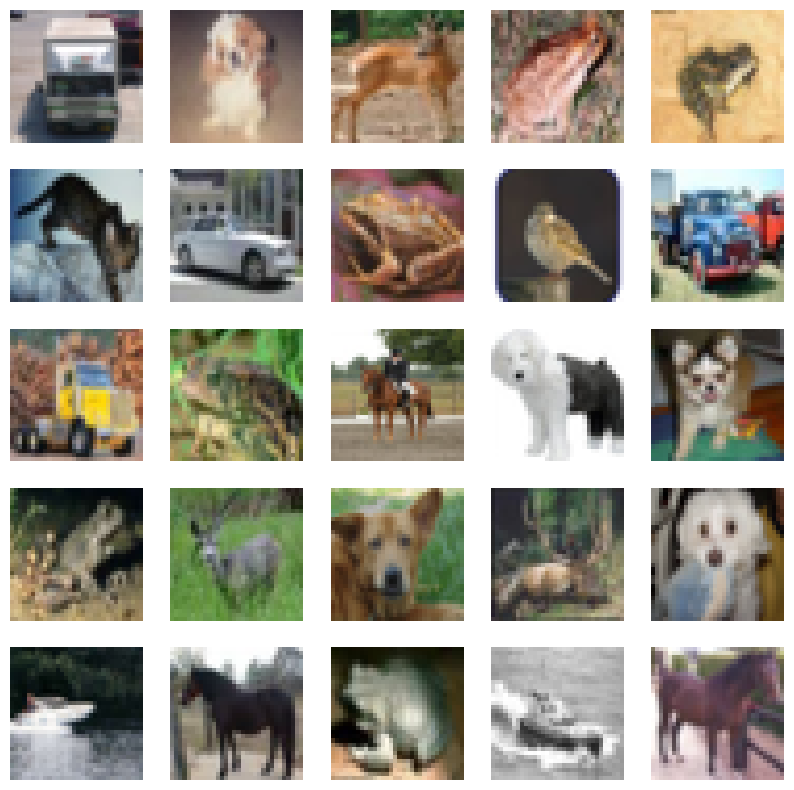

In [83]:
x, _ = next(iter(train_loader))
show_examples(x)

In [5]:
schedule = 1 - np.linspace(0, 1.0, timesteps + 1)
def forward_process(x, t):
    a = schedule[t]
    b = schedule[t + 1]

    noise = np.random.normal(size=x.shape)
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b

def generate_timestep(num):
    return np.random.randint(0, timesteps, size=num)

Now that we have the forward diffusion process defined, we can look at what the images look like after many timesteps.

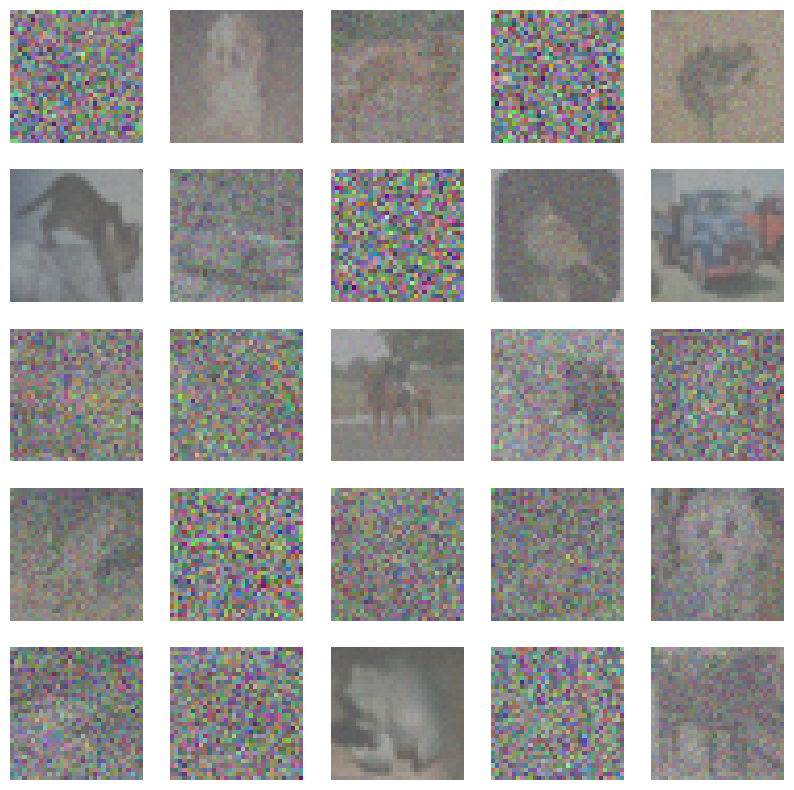

In [87]:
t = generate_timestep(25)
a, b = forward_process(x[:25], t)
show_examples(a)

In [88]:
# A single block for the U-Net architecture used in the diffusion model
class Block(nn.Module):
    def __init__(self, in_channels=128, size=32):
        super(Block, self).__init__()

        self.conv_param = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)

        self.dense_timestep = nn.Linear(192, 128)

        self.layer_norm = nn.LayerNorm([128, size, size])

    def forward(self, x_img, x_timestep):
        x_parameter = F.relu(self.conv_param(x_img))

        time_parameter = F.relu(self.dense_timestep(x_timestep))
        time_parameter = time_parameter.view(-1, 128, 1, 1)
        x_parameter = x_parameter * time_parameter

        x_out = self.conv_out(x_img)
        x_out = x_out + x_parameter
        x_out = F.relu(self.layer_norm(x_out))

        return x_out

In [89]:
# Construct the u-net
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.l_ts = nn.Sequential(
            nn.Linear(1, 192),
            nn.LayerNorm([192]),
            nn.ReLU(),
        )

        # u-Net down blocks
        self.down_x32 = Block(in_channels=3, size=32)
        self.down_x16 = Block(size=16)
        self.down_x8 = Block(size=8)
        self.down_x4 = Block(size=4)

        # middle feed-forward layers
        self.mlp = nn.Sequential(
            nn.Linear(2240, 128),
            nn.LayerNorm([128]),
            nn.ReLU(),

            nn.Linear(128, 32 * 4 * 4), # make [-1, 32, 4, 4]
            nn.LayerNorm([32 * 4 * 4]),
            nn.ReLU(),
        )

        # u-net up blocks
        self.up_x4 = Block(in_channels=32 + 128, size=4)
        self.up_x8 = Block(in_channels=256, size=8)
        self.up_x16 = Block(in_channels=256, size=16)
        self.up_x32 = Block(in_channels=256, size=32)

        self.cnn_output = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)

        # optimizer
        self.opt = torch.optim.Adam(self.parameters(), lr=0.0008)

    def forward(self, x, x_ts):
        x_ts = self.l_ts(x_ts)

        # ----- left ( down ) -----
        blocks = [
            self.down_x32,
            self.down_x16,
            self.down_x8,
            self.down_x4,
        ]
        x_left_layers = []
        for i, block in enumerate(blocks):
            x = block(x, x_ts)
            x_left_layers.append(x)
            if i < len(blocks) - 1:
                x = F.max_pool2d(x, 2)

        # ----- MLP -----
        x = x.view(-1, 128 * 4 * 4)
        x = torch.cat([x, x_ts], dim=1)
        x = self.mlp(x)
        x = x.view(-1, 32, 4, 4)

        # ----- right ( up ) -----
        blocks = [
            self.up_x4,
            self.up_x8,
            self.up_x16,
            self.up_x32,
        ]

        for i, block in enumerate(blocks):
            x_left = x_left_layers[len(blocks) - i - 1]
            x = torch.cat([x, x_left], dim=1)

            x = block(x, x_ts)
            if i < len(blocks) - 1:
                x = F.interpolate(x, scale_factor=2, mode='bilinear')

        # ----- output -----
        x = self.cnn_output(x)

        return x


In [90]:
model = Model().to(device)

Here, we can see the predictions of the untrained diffusion model, which all approximate to the same noise.

  0%|          | 0/16 [00:00<?, ?it/s]

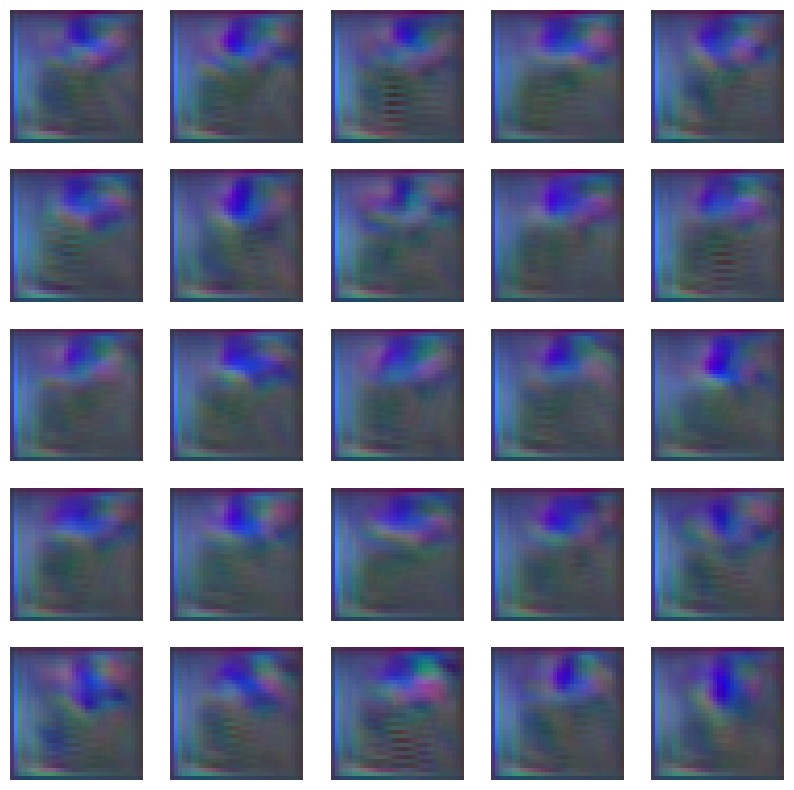

In [92]:
def predict(x_idx=None):
    x = torch.randn(32, 3, image_dim, image_dim).to(device)
    with torch.no_grad():
        for i in trange(timesteps):
            t = i
            x = model(x, torch.full([32, 1], t, dtype=torch.float, device=device))

    show_examples(x.cpu())

predict()

And we can use this function to view each timestep of the diffusion process in order.

  0%|          | 0/16 [00:00<?, ?it/s]

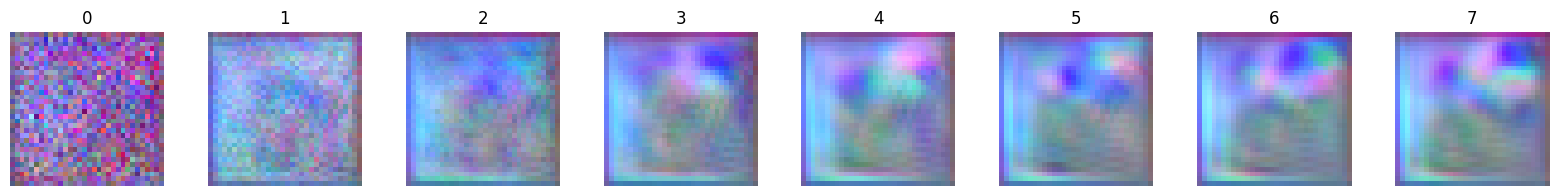

In [95]:
def predict_step():
    xs = []
    x = torch.randn(size=(8, 3, image_dim, image_dim), device=device)

    with torch.no_grad():
        for i in trange(timesteps):
            t = i
            x = model(x, torch.full([8, 1], t, dtype=torch.float, device=device))
            if i % 2 == 0:
                xs.append(x[0].cpu())
    xs = torch.stack(xs, dim=0)
    xs = torch.clip(xs, -1, 1)
    xs = convert_image(xs)

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(xs[i])
        plt.title(f'{i}')
        plt.axis('off')

predict_step()

In [96]:
def train_one(x_img):
    x_ts = generate_timestep(len(x_img))
    x_a, x_b = forward_process(x_img, x_ts)

    x_ts = torch.from_numpy(x_ts).view(-1, 1).float().to(device)
    x_a = x_a.float().to(device)
    x_b = x_b.float().to(device)

    y_p = model(x_a, x_ts)
    loss = torch.mean(torch.abs(y_p - x_b))
    model.opt.zero_grad()
    loss.backward()
    model.opt.step()

    return loss.item()

In [100]:
total = len(train_loader)
bar = trange(25)
for i in bar:
    for j, (x_img, _) in enumerate(train_loader):
        loss = train_one(x_img)
        pg = (j / total) * 100
        if j % 5 == 0:
            bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

  0%|          | 0/25 [00:00<?, ?it/s]

Now that the model is trained, we can see some generations below!

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

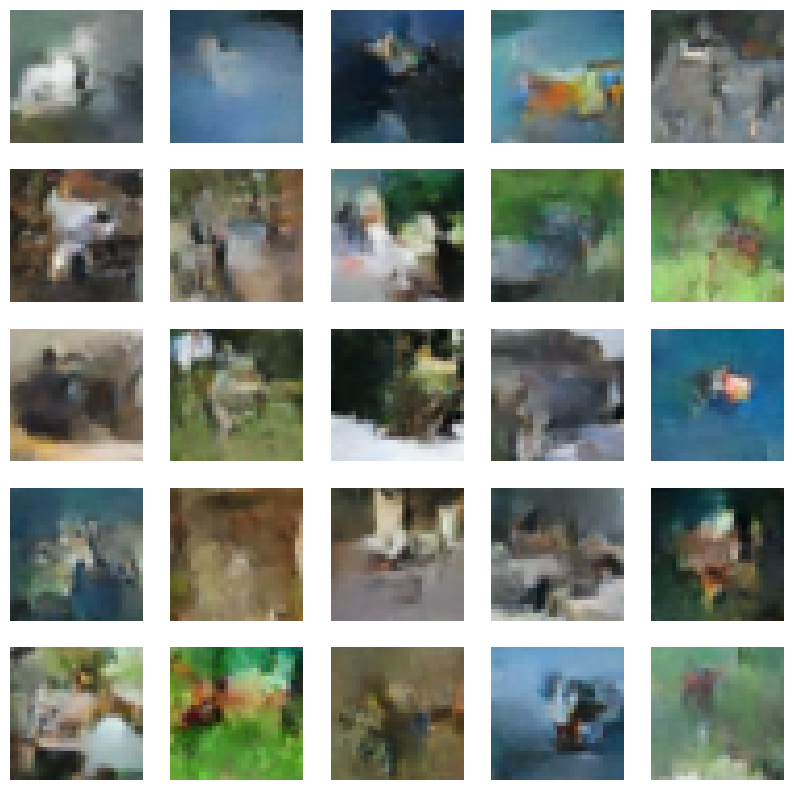

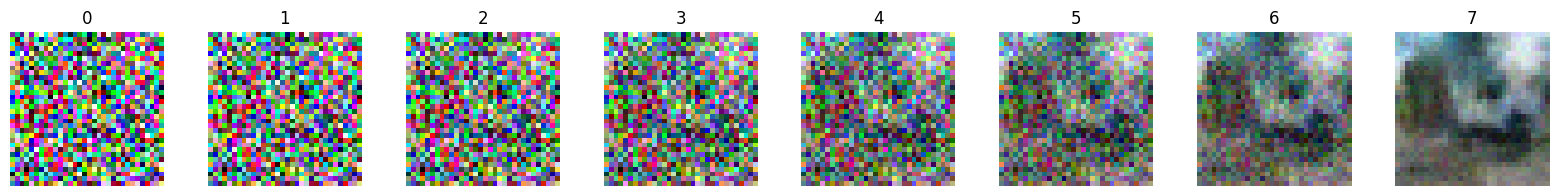

In [101]:
predict()
predict_step()

  0%|          | 0/16 [00:00<?, ?it/s]

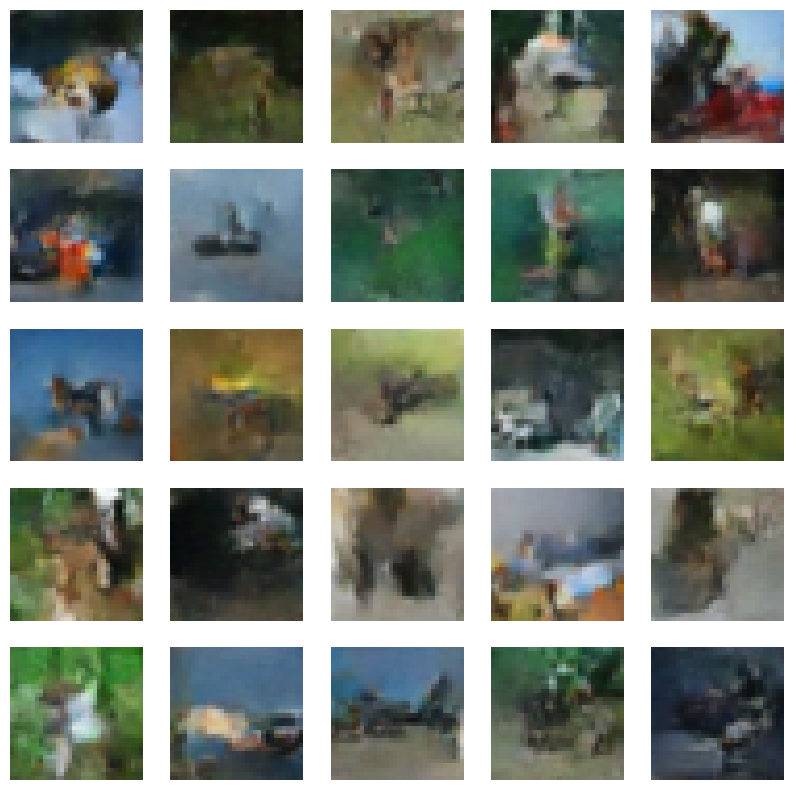

In [103]:
predict()

  0%|          | 0/16 [00:00<?, ?it/s]

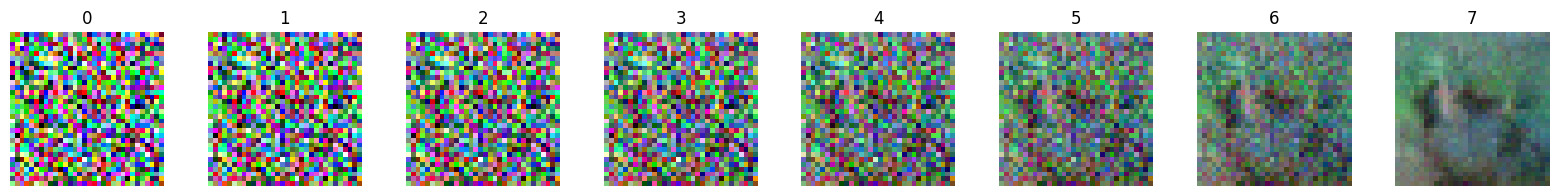

In [102]:
predict_step()